<a id='logbook'></a>
# Prediction of roll damping using fully nonlinear potential flow and Ikeda's method

In [54]:
# %load ../../notebooks/imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

#from jupyterthemes import jtplot
#jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import src.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables
import shipflowmotionshelpers.shipflowmotionshelpers as helpers


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
from rolldecayestimators import fit_on_amplitudes
from reports import mdl_results
import rolldecayestimators.ikeda as ikeda_classes
from pyscores2.indata import Indata
from pyscores2.output import OutputFile
import joblib
import src.visualization.visualize as visualize

# Abstract

# Nomenclature
| Variable | Explain |
|---|---|
|$\pi$| example |

# Introduction
Many great semi-empirical methods have been developed over the years to analyze various aspects of ship hydrodynamics such as:  resistance,  propulsion  and  seakeeping. These methods were often developed because solving the actual flow was far to complicated and far to time consuming at the time. When computers are now faster and great advancement in field of Computation Fluid Dynamics (CFD) has been achieved, the simpler semi-empirical formulas have now gotten less and less relevant. But have they all of gotten totally irrelevant? 

A semi-empirical method to predict ship roll damping, comonly known as Ikeda's method, will be investigated in this paper, for a use case that can still make it relevant. It will be investigated if this method can be used to increase the accuracy of the roll motion prediction of a nonlinear potential flow method (FNPF), so that this relatively fast option can be used to a larger extent than what is currently possible today. The roll damping of ship is higly depending on vicsous effects which mean that the invicid potential flow lacks a lot of the important physics of the roll motion and can therefore not give relevant results for this degree of freedom, where more advanced options such as: model test or URANS are needed.  

The hybrid method, combining Ikeda's method and FNPF proposed in this paper is investigated using the well known KVLCC2 test case ([Body plan](../../notebooks/11.1_KVLCC2_geometry.ipynb#bodyplan)). 

![Body plan](../figures/KVLCC2_body_plan.png)

This ship was selected partly because it is a well known test case, there were model tests data available from SSPA and also because it does not have any bilge keels. The Ikeda's metod contain methods to predict damping from various component, where the bilge keels is one of them. From the model tests, only the total damping can be observed. Reducing the number of components by having no bilge keels would therefore give more insight into the remaining ones. 

Revisinging these older semi-empirical methods can also help us to understand the hydrodynamics better.

In [3]:
file_paths = [
    '../../data/external/kvlcc2_rolldecay_0kn',
    '../../data/external/kvlcc2_rolldecay_15-5kn',
]
df_parameters = pd.DataFrame()
df_parameters =  helpers.load_parameters(file_path=file_paths)
parameters = df_parameters.iloc[-1]

In [4]:
interesting = [
    'title',
    'LPP',
    'B',
    'ZCG',
    'KXX',
    'S',
    'V',
    'dens',
    'ta',
    'tf',
]
table_parameters = pd.DataFrame(parameters[interesting]).transpose()
table_parameters

,title,LPP,B,ZCG,KXX,S,V,dens,ta,tf
kvlcc2_rolldecay_15-5kn,KVLCC2,4.706,0.853,0.274,0.341,5.981,0.993,1000,0.3059,0.3059


# Methods

## Roll decay test
The initial heel angle during the roll decay tests gives the ship potential energy that is shifting to kinetic energy as the ship starts to move during the inital phase of the roll decay test. The energy is transfered between kinetic energy and potential energy during the oscillations. The ship loses energy over time due to the damping wich can be seen in this [plot](../../notebooks/02.2_ikeda_Be_assumption.ipynb#energy)
![](../figures/energy_transfer.png)

## PIT

A parameters identification technique (PIT) similar to <cite data-cite="7505983/EXYJELCU"></cite> is used to obtain the damping coefficients from the roll decay model test as well as from the FMTP simulated roll decay tests. In this technique, parameters in a mathematical model are determined to get the best fit to a roll decay time signal. A derivation of a matematical model suitable for this study is described below together with a description of how the parameters: damping, stiffness and inertia coefficients where determined.    

The general differential equation for a linearly decaying motion can be written as:

In [5]:
Math(vlatex(equations.diff_eq))

<IPython.core.display.Math object>

Which has an analytical solution <cite data-cite="7505983/KL7A3RIV"></cite>:

In [6]:
Math(vlatex(equations.analytical_solution))

<IPython.core.display.Math object>

Which as in the usual case of having no initial roll velocity ($\phi_0=0$) can be simlified to:

In [7]:
no_initial_speed = sp.simplify(equations.analytical_solution.subs(symbols.phi_0_dot,0))
Math(vlatex(no_initial_speed))

<IPython.core.display.Math object>

And the damping coefficient $\zeta$ is very small for ships so that $\sqrt{1-\zeta}$ is almost 1 and the solution can be further simplified, into something that can easily be recognized as a decaying oscillation:

In [8]:
no_initial_speed_zeta_small = no_initial_speed.subs(
    [(sp.sqrt(1-symbols.zeta**2),1),
     (symbols.zeta*sp.sin(symbols.omega0*symbols.t),0),
    ])
Math(vlatex(no_initial_speed_zeta_small))

<IPython.core.display.Math object>

For a ship the rolling motion during a roll decay can be expressed in general form according to <cite data-cite="7505983/RWXBIIJJ"></cite>:

In [9]:
Math(vlatex(equations.roll_decay_equation_general_himeno))

<IPython.core.display.Math object>

Where $B_{44}(\dot{\phi})$ and $C_{44}(\phi)$ are the damping and stiffness models. A cubic model can be obtained by using cubic damping and stiffness models:

In [10]:
Math(vlatex(equations.b44_cubic_equation))

<IPython.core.display.Math object>

In [11]:
Math(vlatex(equations.restoring_equation_cubic))

<IPython.core.display.Math object>

So that the total equation is written:

In [12]:
Math(vlatex(equations.roll_decay_equation_cubic))

<IPython.core.display.Math object>

This mathematical model can be reduced to a quadratic damping model when $B_3=0$ and a linear model when $B_2=B_3=0$. This equation does not have one unique solution. If all parameters would be  multiplied by a factor $k$ these parameters also be a solution to the equation. All parameters are therefore divided by the total added mass parameters $A_44$ where parameters such as:

In [13]:
equations.normalize_equations[symbols.B_1]

Eq(B_1A, B_1/A_44)

So that the equation with these unique parameters can be written:

In [14]:
Math(vlatex(equations.roll_decay_equation_cubic_A))

<IPython.core.display.Math object>

The parameters of this equation can be identified using least square fit if the time signals $\phi(t)$, $\dot{\phi}(t)$ and $\ddot{\phi}(t)$ are all known. This is the case for the results from the FNPF simulations but not from the model tests, where only the roll signal $\phi(t)$ is known. The other time derivatives can be estimated using numerical derivation of a low pass filtered roll signal or Kalman filtered roll signal. The filtering will however introduce some errors in itself. 
Instead of using this "Derivation approach", it has been found that solving the differential equation numerically for guessed parameter values and then using optimization to make really good guesses similarly to what was used by <cite data-cite="7505983/FJHQJJUH"></cite> and <cite data-cite="7505983/9B7QMVJJ"></cite> gives the best parameter estimation. One problem with this "Integration approach" is that in order to converge, the optimization needs a resonable first guess of the parameters. The Derivation approach has therefore been used as a pre-step to obtain a very good first guess of the parameters that can be passed on to the Integration approach. This has been used for both signals from FNPF and model tests where in the latter case numerical derivation is used.

The differential equation is numerically solved as an intial value problem, where the initial states for $\phi(t)$, $\dot{\phi}(t)$ and $\ddot{\phi}(t)$ are used to estimate the following states, by conducting very small time steps using the follownig expression for the acceleration: 

In [15]:
eq_phi1d = sp.Eq(symbols.phi_dot_dot,
      sp.solve(equations.roll_decay_equation_cubic_A,symbols.phi_dot_dot)[0])

accelaration_lambda = lambdify(sp.solve(eq_phi1d,symbols.phi_dot_dot)[0])

Math(vlatex(eq_phi1d))

<IPython.core.display.Math object>

This numerical solution can be compared with the analytical solution above for a linear model. For this case the relation between $\zeta$ and $B_1$ can be expressed as: 

In [28]:
equations.B_1_zeta_eq

Eq(B_1, 2*A_44*omega0*zeta)

and the natural frequency can be obtained from:

In [30]:
A_44_eq = sp.Eq(symbols.A_44, equations.A44)

eqs = [
    A_44_eq,
    equations.C_equation_linear,

]
omega0_eq = sp.Eq(symbols.omega0,sp.solve(eqs, symbols.omega0, symbols.GM)[1][0])
omega0_eq = omega0_eq.subs(symbols.C,symbols.C_1)
omega0_lambda = lambdify(sp.solve(omega0_eq, symbols.omega0)[0])
omega0_eq

Eq(omega0, sqrt(C_1/A_44))

The analytical and numerical solutions are vary similar according to the example: $A_{44} = 1.0$, $B_1 = 0.3$, $C_1 = 5.0$ shown in the figure below.

In [20]:
eqs = [
    equations.B_1_zeta_eq,    
    equations.analytical_solution,
      ]

analytical_solution_B_1 = sp.Eq(symbols.phi,
                                sp.simplify(sp.solve(eqs,symbols.zeta,symbols.phi)[0][1]))
analytical_lambda = lambdify(sp.solve(analytical_solution_B_1,symbols.phi)[0])

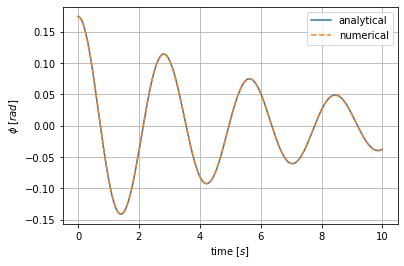

In [34]:
class RollDecayStateSpace():
    
    def __init__(self,B_1A, C_1A, B_2A=0, B_3A=0, C_3A=0, C_5A=0):
        self.parameters = {
            'B_1A':B_1A, 
            'B_2A':B_2A, 
            'B_3A':B_3A, 
            'C_1A':C_1A, 
            'C_3A':C_3A, 
            'C_5A':C_5A}
            
    def time_step(self,t,states):
        
        phi = states[0]
        phi1d = states[1]
        phi2d = accelaration_lambda(**self.parameters, phi=phi, phi1d=phi1d)
        
        d_states_dt = np.array([phi1d, phi2d])
        return d_states_dt
    
    def simulate(self,t,phi0=np.deg2rad(10),phi1d0=0):
        
        initial_state = [phi0,phi1d0]
        
        t_span = [t[0], t[-1]]
        
        result = solve_ivp(fun=self.time_step, t_span=t_span,  y0=initial_state, t_eval=t)
        assert result.success
        df_result = pd.DataFrame(index=result.t, data=result.y.T, columns = ['phi','phi1d'])
        return df_result
    
A_44 = 1.0
B_1 = 0.3
C_1 = 5.0
B_1A = B_1/A_44
C_1A = C_1/A_44
omega0=omega0_lambda(A_44=A_44, C_1=C_1)

t = np.linspace(0,10,1000)
phi_0=np.deg2rad(10)
phi_01d=0

## State space:
model = RollDecayStateSpace(B_1A=B_1A, C_1A=C_1A)

df_state_space = model.simulate(t=t, phi0=phi_0, phi1d0=phi_01d)

## Analytical
phi_analytical = analytical_lambda(A_44=A_44, B_1=B_1, omega0=omega0, phi_0=phi_0, phi_01d=phi_01d, 
                                  t=t)


fig,ax=plt.subplots()
ax.plot(t, phi_analytical, '-', label='analytical')
df_state_space.plot(y='phi', style='--', ax=ax, label='numerical')
ax.set_ylabel(r'$\phi$ $[rad]$')
ax.set_xlabel(r'time $[s]$')
ax.grid(True)
ax.legend()

## Implementation of Ikeda's method
Ikeda's method divides roll damping into five damping components: the friction component $B_F$, the eddy component $B_E$, the lift component $B_L$, the wave component $B_W$ and the bilge keel component $B_{BK}$, as in the following, 

\begin{equation}
B_{44} = B_F + B_E + B_L + B_W + B_{BK}
\end{equation}

Due to the absence of bilge keels for the KVLCC2 the $B_{BK}$ does not need to be included. This means that remaining components will get all the attention in this paper. Ikeda has in a series of papers proposed semi empirical formulas for the viscous damping components: $B_F$, $B_E$ and $B_L$ which have been implemented for this study. The wave damping $B_W$ is calculated using a potential flow strip theory code or a more advance potential flow code such as the FNPF method described as the Hybrid method in this paper.      

Ikeda produced many papers about various aspects of roll damping where most of them are translations from original manuscripts in Japanese. Summaries of this method <cite data-cite="7505983/RWXBIIJJ"></cite>, <cite data-cite="7505983/KAKIM2E2"></cite> and <cite data-cite="7505983/UGK6YEVD"></cite> has been used together with the original papers to understand how the method should be implemented. Falzarano says that the Himeno report and associated computer programs are well-known to have numerous typographical errors. When looking at these resources it becomes evident that there is some variety on how the method should be implemented, regardless if this is due to typographical errors or being variations of the actual method. The implementation was therefore a fairly time consuming task where various alternative implementations needed to be compared and investigated. 

The scale effects of roll damping is considered to mainly be associated with the sking friction component <cite data-cite="7505983/RWXBIIJJ"></cite>. This component makes a very small part of the total damping for the full scale ship, but a substantial part for the model scale ship used in this study. This is the only component in ikedas method that needs to be recalculated when the scale changes.  

For the skin friction damping $B_F$ implementation was made according to the description in <cite data-cite="7505983/UGK6YEVD"></cite>. With the difference that the actual wetted surface $S$ was used instead of the proposed estimation formula. 

The hull lift damping $B_L$ is calculated according to <cite data-cite="7505983/ZVF3F5V5"></cite> and implemented as described in <cite data-cite="7505983/RC2WJ4RI"></cite>. Journe added a linear interpolation to the values for $\kappa$ that were suggested by Ikeda.


In [39]:
mdl_results.df_rolldecays

,project_number,series_number,run_number,test_number,model_number,ship_name,loading_condition_id,ascii_name,ship_speed,comment,file_path_ascii,file_path_ascii_temp,file_path_log,file_path_hdf5,date,test_type,facility,angle1,angle2,Körfallstyp,name,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,scale_factor,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,CFP,AIX,PDTDES,RTYPE,SFP,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,AI,HSKEG,RSKEG,LOA,ship_type_id,rho,g
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21338,40178362,1,95,1,M5057-01-A,M5057-01-A,166,95.0,0.0,"Roll decay, 0 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-04-03,roll decay,MDL,None,None,None,20.8,11.2672,18.6,5.73,None,20.8,20.8,None,23.2,80.0,None,None,312653.0,0.99538,None,68.0,320.0,58.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1000,9.81
21340,40178362,1,97,1,M5057-01-A,M5057-01-A,166,97.0,15.5,"Roll decay, 15.5 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-04-04,roll decay,MDL,None,None,None,20.8,11.2672,18.6,5.73,None,20.8,20.8,None,23.2,80.0,None,None,312653.0,0.99538,None,68.0,320.0,58.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1000,9.81


Text(0.5, 1.0, '$F_n$:0.14 $[-]$')

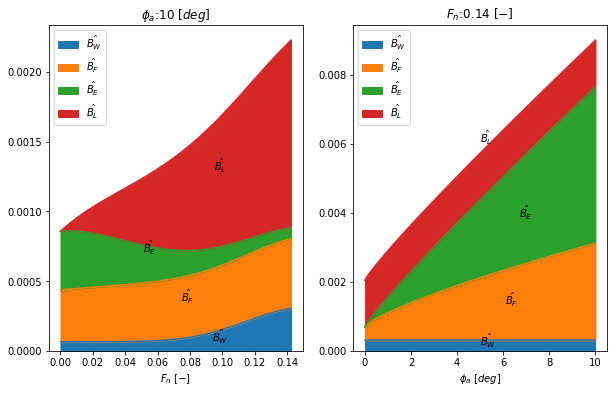

In [77]:
mdl_meta_data = mdl_results.df_rolldecays.iloc[0]
scale_factor = mdl_meta_data.scale_factor
N = 200
V = np.linspace(0,15.5,N)*1.852/3.6/np.sqrt(scale_factor)
kg=mdl_meta_data.kg/scale_factor

## Load ScoresII results
indata = Indata()
indata.open(indataPath='../../models/KVLCC2_speed.IN')
output_file = OutputFile(filePath='../../data/interim/KVLCC2_speed.out')
phi_a_deg = 10
phi_a = np.deg2rad(phi_a_deg)*np.ones(N)

model_mdl = joblib.load('../../models/KVLCC2_speed.pkl')

ikeda_estimator = ikeda_classes.Ikeda.load_scoresII(V=V, 
                                                    w=model_mdl['estimator'].omega0, 
                                                    fi_a=phi_a, 
                                                    indata=indata, 
                                                    output_file=output_file, 
                                scale_factor=scale_factor, BKL=0, BKB=0, kg=kg)

results = ikeda_estimator.calculate()
results['V'] = V
results['fn'] = fn = V/np.sqrt(ikeda_estimator.lpp*ikeda_estimator.g)
results.set_index('fn', inplace=True)

phi_as = np.linspace(0,phi_a_deg,N)
ikeda_estimator2 = ikeda_classes.Ikeda.load_scoresII(V=np.max(V), 
                                                    w=model_mdl['estimator'].omega0, 
                                                    fi_a=phi_as, 
                                                    indata=indata, 
                                                    output_file=output_file, 
                                scale_factor=scale_factor, BKL=0, BKB=0, kg=kg)

results2 = ikeda_estimator2.calculate()
results2['phi_a'] = phi_as
results2.set_index('phi_a', inplace=True)

fig,axes=plt.subplots(ncols=2)
fig.set_size_inches(10, 6)
rename = {
    'B_W_hat':r'$\hat{B_W}$',
    'B_F_hat':r'$\hat{B_F}$',
    'B_E_hat':r'$\hat{B_E}$',
    'B_L_hat':r'$\hat{B_L}$',
}

interesting_=['B_W_hat', 'B_F_hat', 'B_E_hat', 'B_L_hat']
interesting2 = [rename[key] for key in interesting_]

ax=axes[0]
results_ = results.rename(columns=rename)
visualize.plot_area(results_, ax=ax, interesting_=interesting2)
ax.set_xlabel(r'$F_n$ $[-]$');
ax.set_title(r'$\phi_a$:%0.0f $[deg]$' % phi_a_deg)

ax=axes[1]
results_ = results2.rename(columns=rename)
visualize.plot_area(results_, ax=ax, interesting_=interesting2)
ax.set_xlabel(r'$\phi_a$ $[deg]$');
ax.set_title(r'$F_n$:%0.2f $[-]$' % np.max(fn))

### Eddy damping
The current implementation was benchmarked with the data from Ikeda's oringinal [cylinder experiments](../../notebooks/08.1_ikeda_eddy.ipynb). It seems that the current implementation underpredicts the damping.

![](../../notebooks/ikeda_eddy_section_A.PNG)

## FNPF

## Hybrid method

# Results

## Roll decay model tests
### 0 knots
Data from two roll decay model tests conducted at zero speed were available: [Roll decay model tests 0 knots](../../notebooks/01.2_select_suitable_MDL_test_KLVCC2.ipynb#rolldecay). These tests where analyzed by fitting a [Cubic model](../../notebooks/01.2_select_suitable_MDL_test_KLVCC2.ipynb#cubic_model) to the model test data. The two models were very similar in terms of roll damping and stiffness, suggesting good repeatability in the model tests as well as in the parameter identification technique (PIT) used. The total damping at zero speed is very low for this vessel, where it takes at least one hundred oscillations for the motion to decay. Since the ship has no bilge keel, the friction damping and eddy damping will be the only damping contributions acting. These contributions are also rather small.   

Roll decay test was also simulated using [FNPF](../../notebooks/06.1_KVLCC2_motions.ipynb#damping). The damping was much higher than the predicted valued using Strip Theory.

### 15.5 knots
Data from one roll decay model tests conducted at a ship speed corresponding to 15.5 knots full scale ship speed was also available. This model tests was analyzed in the same way as the other tests at zero knots. It was found that the damping was higher at speed. The ship got a small [yaw rate](../../notebooks/01.3_select_suitable_MDL_test_KLVCC2_speed.ipynb#yawrate) at the end of test, giving a small steady roll angle due to the centrifugal force. Since this effect is not included in the matematical model used, the steady roll angle was instead removed by removing the linear trend in the roll angle signal. 




## Roll damping prediction with Ikeda's method
Calculated the roll damping with Ikeda's method for zero speed and 15.5 knots. The damping was [compared](../../notebooks/04.3_KVLCC2_Ikedas_model_tests.ipynb#speeds) with corresponding values obtained from the model tests. The results showed good agreement between the model tests and predictions at speed. The damping predicted with Ikeda's method at zero knots was significantly higher than the corresponding model test. The predicted eddy damping was very large and is most likey overpredicted.  

Much effort was made to investigate the eddy damping prediction of the Ikeda's method implementation. It was found, by conducting a sensitivity analysis, that the predicted eddy damping was extremely sensitive to ship sections with almost rectangular shape, where the section area coefficient [sigma](../../notebooks/08.2_ikeda_eddy_sigma.ipynb) was close to one. According to Kawahara the mid section coefficient should not exceed 0.99, which otherwise seem to give a huge extrapolation error according to the [figure](../../notebooks/08.2_ikeda_eddy_sigma.ipynb) above. This was however the case for many of the sections of the KVLCC2, where the limiting value was instead used, to avoid unrealistic extrapolation errors.

It seems that mid section coefficient most often exceeds 0.99 based on statistics from MDL tests during the past 15 years: [plot](../../notebooks/09.1_sigma_statistics.ipynb)

Eddy damping gets smaller as the speed increases and has almost vanished for the 15.5 knots which can be seen in [plot](../../notebooks/06.1_KVLCC2_motions.ipynb#speed). So the difficulties with eddy damping prediction for high mid section coefficients is mostly a low speed problem; And in the presens of bilge keels, the bilge keel damping would be the dominating contribution to the roll damping at low speed as can be seen in <cite data-cite="7505983/FJHQJJUH"></cite>. So this is mostly a problem at low speed for ships without bilge keels.

Attempts where made to use Ikeda's alternative eddy damping formula for barges. This one did not work the $B_E$ is far to large: [07.1_ikeda_barge](../../notebooks/07.1_ikeda_barge.ipynb)


## Combined method
Roll damping was predicted using the [Combined method](../../notebooks/06.1_KVLCC2_motions.ipynb#combined_damping). The damping witht the combined method seems to underpredict the damping at zero speed.

# Conclusions

# References
<div class="cite2c-biblio"></div>